- Created: 2018-12-08
- Last modified: 2018-12-08
- Purpose: to compare existing network `refseq75` to string data base E.coli PPI

- Steps:
1. ran diamond blastp --query REPRESENTING-GENES-ECOLI --db STRING-DB-SEQUENCES
2. extract max `pident`, identity for each **STRING DB ID** (ex: 511145.b0002)
3. remove all matches with less than 70% pident; 70% becuase we built pan-genome based on 70% threshold
4. compare the links predicted by our net (refseq90) and STRING DB

- Results: very few overlap

- Interpretation
1. There might be some problems with our net
2. Our Net is trained based on GO-term sharing for functional prediction. Not all PPI has GO-term sharing (but expect many of them should have)

In [1]:
import pandas as pd
selected_edge = pd.read_csv('/home/hermuba/data0118/goldstandard/EC70_string_edges')

In [12]:
selected_edge.shape

(1159522, 6)

In [35]:
selected_edge.head()

,Unnamed: 0,protein1,protein2,combined_score,gene_one,gene_two
0,26,511145.b0002,511145.b3397,449,JMUY01000009_514386703,FLXF01000003_9056212961
1,27,511145.b0002,511145.b1338,453,JMUY01000009_514386703,JMVB01000033_11114386733
2,28,511145.b0002,511145.b1686,214,JMUY01000009_514386703,JMUY01000001_88514386703
3,29,511145.b0002,511145.b1341,167,JMUY01000009_514386703,NIPT01000031_756217733
4,30,511145.b0002,511145.b0060,180,JMUY01000009_514386703,FLWH01000007_15756212962


In [14]:
selected_edge['gene_one']=selected_edge['gene_one'].str.replace('|', '').str.replace('.', '')
selected_edge['gene_two']=selected_edge['gene_two'].str.replace('|', '').str.replace('.', '')

# INPUT our net `eskape` and `refseq`

In [8]:
def our_net_to_df(fname):
    our_net = pd.read_csv(fname, sep = ',', names = ['gene_one', 'gene_two','mutual_info', 'nrm_mutual'])
    return(our_net)

In [9]:
# merge with refseq90
refseq_path = '/home/hermuba/data0118/network1122/refseq_ordinary_40'
refseq = our_net_to_df(refseq_path)

In [10]:
refseq.head()

,gene_one,gene_two,mutual_info,nrm_mutual
2281,JAPE01000025_10014001573,56223530con0006_18756223530,0.030776,0.705562
2329,JAPE01000025_10014001573,JAPE01000025_9414001573,0.046902,0.898091
5147,56222862con0019_156222862,JMUY01000005_55714386703,0.451230,0.760022
5485,56222862con0019_156222862,JMUY01000002_18614386703,0.468346,0.681487
5544,56222862con0019_156222862,56222549con0008_156222549,0.411484,0.659049


In [11]:
refseq.shape #significantly less than string

(478627, 4)

# compare interaction between `our net` and `STRING`

In [15]:
def compare_net(our_net, string):
    
    our_links = [frozenset(x) for x in our_net[['gene_one', 'gene_two']].values]
    string_links = [frozenset(x) for x in string[['gene_one', 'gene_two']].values]
    
    print(type(our_links))
    ours = set(our_links)
    strs = set(string_links)
    
    
    return(len(ours.intersection(strs)), ours, strs)

In [16]:
common, ours, strs = compare_net(refseq, selected_edge)

<class 'list'>


In [20]:
common #refseq hits 43253/1460960

43253

In [18]:
len(strs)

460960

In [19]:
len(ours) # 1/10 is supported by STRING

478627

In [22]:
# merging network
path = '/home/hermuba/data0118/network1122/'
fname = 'refseq_ordinary_40'
import networkx as nx
net = nx.read_edgelist(path + fname + '_edgelist', delimiter = ',', nodetype = str,)

In [23]:
selected_edge[['gene_one', 'gene_two']].to_csv(path + 'string_edgelist', index = False, header = False, na_rep = 'nan')

In [40]:
str_net = nx.read_edgelist(path + 'string_edgelist', delimiter = ',', nodetype = str,)

In [27]:
import numpy as np
def degree_dis(net):
    degree_sequence = [d for n, d in net.degree()]


    degree_sequence = np.asarray(degree_sequence)
    return(degree_sequence)


In [42]:
d = degree_dis(str_net)
hist, bins = np.histogram(d, bins = 50)

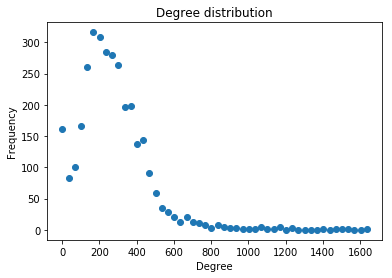

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('Degree distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.scatter(bins[:-1], hist)

/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hermuba/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2320: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Text(3, 3, 'r=nan')

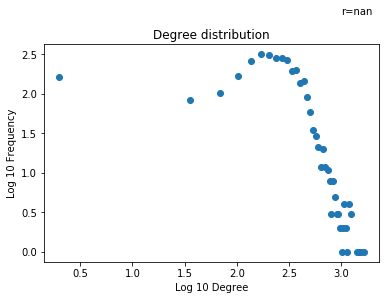

In [45]:
from scipy import stats
logx = np.log10(bins[:-1])
logy = np.log10(hist)

slope, intercept, r_value, p_value, std_err = stats.linregress(logx, logy)
line = slope*logx+ intercept


plt.title('Degree distribution')
plt.xlabel('Log 10 Degree')
plt.ylabel('Log 10 Frequency')
plt.plot(logx, logy, 'o',logx, line)
plt.text(3,3,'r='+str(slope))

In [50]:
combined = nx.compose(net, str_net)

In [51]:
combined.number_of_edges()

896334

In [53]:
combined.number_of_nodes()

18500

In [55]:
hist

array([13541,   814,   410,   401,   451,   354,   305,   254,   226,
         193,   193,   140,   124,   119,    64,    67,    66,    61,
          54,    58,    61,    46,    53,    48,    47,    46,    40,
          50,    34,    31,    37,    26,    19,    22,    22,     7,
           7,     3,     1,     1,     2,     0,     0,     1,     0,
           0,     0,     0,     0,     1])

/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/hermuba/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2320: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Text(3, 3, 'r=nan')

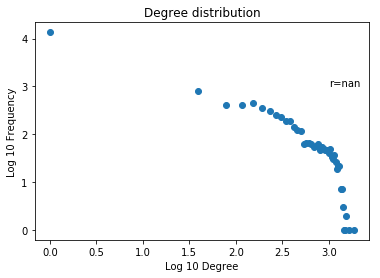

In [52]:
d = degree_dis(combined)
hist, bins = np.histogram(d, bins = 50)
from scipy import stats
logx = np.log10(bins[:-1])
logy = np.log10(hist)

slope, intercept, r_value, p_value, std_err = stats.linregress(logx, logy)
line = slope*logx+ intercept


plt.title('Degree distribution')
plt.xlabel('Log 10 Degree')
plt.ylabel('Log 10 Frequency')
plt.plot(logx, logy, 'o',logx, line)
plt.text(3,3,'r='+str(slope))

In [56]:
net.number_of_nodes()

17097

In [57]:
str_net.number_of_nodes()

3244